In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from sentence_transformers import SentenceTransformer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

/Users/polkate/.pyenv/versions/3.11.5/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
RANDOM_SEED: int = 1
plt.style.use("tableau-colorblind10")

In [3]:
df = pd.read_csv("data/Reddit_Data.csv")
df.dropna(inplace=True)
df.head()

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


We randomly sample `4_000` due to limited computational resources.

In [4]:
df = df.sample(4_000, random_state=RANDOM_SEED)

# Experiments

Our experiments will include the following methods:

| Method     | Type                    |
| ---------- | ----------------------- |
| BERT       | Model-based             |
| tf–idf     | Handwritten/Algorithmic |

## Generating Embeddings

In [5]:
vectorizer = TfidfVectorizer()
vectorizer.fit(df["clean_comment"])
bert = SentenceTransformer("bert-base-cased")

No sentence-transformers model found with name /Users/polkate/.cache/torch/sentence_transformers/bert-base-cased. Creating a new one with MEAN pooling.


In [6]:
tfidf_embs = vectorizer.transform(df["clean_comment"])
bert_embs = bert.encode(df["clean_comment"].to_numpy())
labels = df["category"]

## t-SNE Visualization of tf-idf and BERT Embeddings

In [7]:
tsne = TSNE(random_state=1, n_iter=1_000, init="random")
tfidf_tsne = tsne.fit_transform(tfidf_embs)
bert_tsne = tsne.fit_transform(bert_embs)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/Users/polkate/.pyenv/versions/3.11.5/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


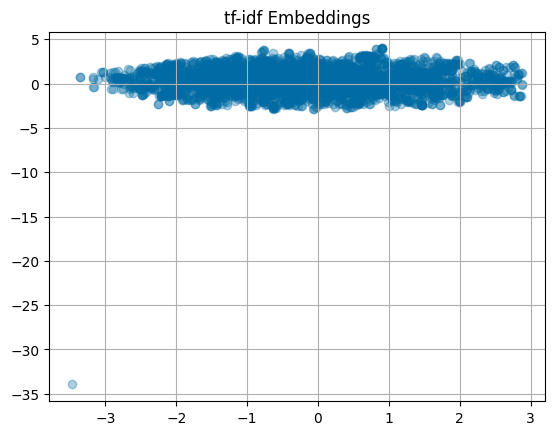

In [8]:
plt.grid()
plt.title("tf-idf Embeddings")
plt.scatter(tfidf_tsne[:, 0], tfidf_tsne[:, 1], alpha=0.32)
plt.savefig("image/tfidf_emb.png")

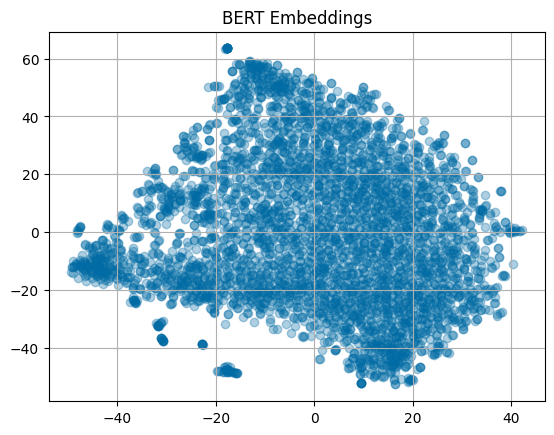

In [9]:
plt.grid()
plt.title("BERT Embeddings")
plt.scatter(bert_tsne[:, 0], bert_tsne[:, 1], alpha=0.32)
plt.savefig("image/bert_emb.png")

## Training Multilayer Perceptron (MLP) Models

In [10]:
tfidf_xs_train, tfidf_xs_test, tfidf_ys_train, tfidf_ys_test = train_test_split(
    tfidf_embs, labels, test_size=0.2, random_state=RANDOM_SEED
)
bert_xs_train, bert_xs_test, bert_ys_train, bert_ys_test = train_test_split(
    bert_embs, labels, test_size=0.2, random_state=RANDOM_SEED
)

## Multilayer Perceptron (MLP) with tf-idf Embeddings

In [11]:
tfidf_model = MLPClassifier(max_iter=10_000)
tfidf_model.fit(tfidf_xs_train, tfidf_ys_train)
print(classification_report(tfidf_ys_test, tfidf_model.predict(tfidf_xs_test)))

              precision    recall  f1-score   support

          -1       0.65      0.46      0.54       171
           0       0.72      0.82      0.77       269
           1       0.74      0.76      0.75       360

    accuracy                           0.72       800
   macro avg       0.70      0.68      0.69       800
weighted avg       0.71      0.72      0.71       800



##  Multilayer Perceptron (MLP) with BERT Embeddings

In [12]:
bert_model = MLPClassifier(max_iter=10_000)
bert_model.fit(bert_xs_train, bert_ys_train)
print(classification_report(bert_ys_test, bert_model.predict(bert_xs_test)))

              precision    recall  f1-score   support

          -1       0.47      0.48      0.47       171
           0       0.70      0.71      0.70       269
           1       0.69      0.67      0.68       360

    accuracy                           0.64       800
   macro avg       0.62      0.62      0.62       800
weighted avg       0.64      0.64      0.64       800



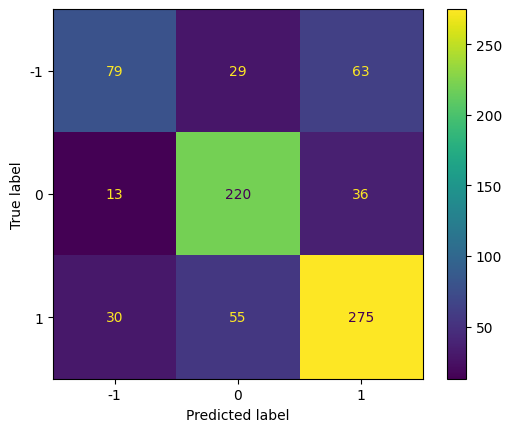

In [13]:
cm = confusion_matrix(
    tfidf_ys_test, tfidf_model.predict(tfidf_xs_test), labels=tfidf_model.classes_
)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tfidf_model.classes_)
disp.plot()
plt.savefig("image/cm.png")

The experimental results show that tf-idf outperformed BERT for this specific task. Therefore, our sentiment classification function will use embeddings generated by tf-idf.

In [14]:
def sentiment(text: str) -> None:
    """Evaluates a sentiment of the given text."""

    val = tfidf_model.predict(vectorizer.transform([text]))
    if val == -1:
        print("Negative")
    elif val == 0:
        print("Neutral")
    else:
        print("Positive")

In [15]:
sentiment("Sad day today...")

Negative


In [16]:
sentiment("I bought shoes today")

Neutral


In [17]:
sentiment("I am very happy!")

Positive
